<a href="https://colab.research.google.com/github/bryanburroughs/ai/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Tensorflow Lite and Raspberry Pi

The following is used in this notebook:


*   Raspberry Pi5
*   Raspberry Pi Camera v3 *(encountered some driver issues with opencv but should work with picamera2)*
*   USB camera *(this is what I ended up using)*
*   Google Colab


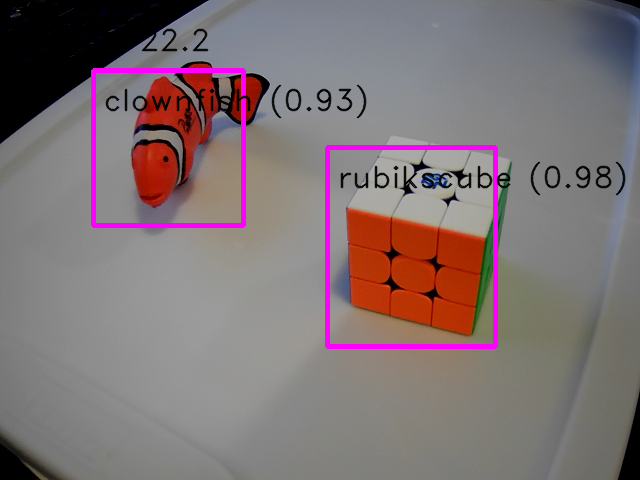

#Capture and Label Images

Note: *This is a draft "cliff notes" version of instructions and is based on the following https://www.youtube.com/watch?v=3YqbO2AlepM*

##Login to the raspberry pi as non-root user

Note: Python can be run using system-wide modules or via a virtual environment. I will use system-wide here.

##Unpack the code:


```
unzip tflite-custom-object-bookworm-main.zip
cd tflite-custom-object-bookworm-main
```


##The following error can be eliminated:
…sudo pip3 install opencv-python
sudo pip3 install mediapipe

```
bryan@raspberrypi:~ $ sudo pip3 install opencv-python
error: externally-managed-environment

Ã This environment is externally managed
â°â> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
```

Fix the issue and install CV and mediapipe
```
sudo rm  /usr/lib/python3.11/EXTERNALLY-MANAGED

…<mark>Bus 001 Device 003: ID 3443:60bb webcamvendor NexiGo N60 FHD Webcam Audio</mark>
Bus 001 Device 001: ID 1d6b:0002 Linux Foundation 2.0 root hub
```

##control camera from commandline to ensure functionality. This can be useful for troubleshooting as well.
```
sudo apt install fswebcam
fswebcam -d /dev/video0 -r 1280x720 --no-banner ./image0.jpg
fswebcam -d /dev/video1 -r 1280x720 --no-banner ./image1.jpg
```
…##Capture 30 frames
I used TigerVNC to login to the desktop of the Raspberry Pi.
There are 2 python scripts that can be used to capture a series of images.
img.py works for USB cameras.
img1.py should work for Pi camera

Edit img.py as needed
```
cat img.py
import cv2
import time
cpt = 0
maxFrames = 30 # 200 is recommended

cap=cv2.VideoCapture(0) #assuming device is at /dev/video0

#modify cv2.imwrite line below according to the image name and location

while cpt < maxFrames:
    ret, frame = cap.read()
    frame=cv2.resize(frame,(640,480))
    cv2.imshow("test window", frame) # show image in window
    #cv2.imwrite("/home/bryan/tflite-custom-object-bookworm-main/images/rubikscube_%d.jpg" %cpt, frame)
    cv2.imwrite('/home/bryan/tflite-custom-object-bookworm-main/images/clownfish_%d.jpg' %cpt, frame)
    time.sleep(0.5) #adjust if more time is needed between pics
    cpt += 1
    if cv2.waitKey(1)&0xFF==27:
        break
cap.release()
cv2.destroyAllWindows()
```
cv2.imwrite should be pointed to the images directory and naming scheme must align with labels that will be generated in labelImg and train.py. Sleep timer can be adjusted if more time is needed between pics.

## Label Images

labelImg can be run on any PC runing Linux, Windows or Mac. I am using the Raspberry Pi here.

##install labelImg software:
```
sudo apt-get install pyqt5-dev-tools
sudo pip3 install labelimg
```

##workaround for labelImg crash on Raspberry Pi
An alternative would be to run labelImg on another server or PC. It works quite well on the Pi using VNC though. We just need to run this GUI app to properly label each object that we want to detect.

```
sudo cp /usr/local/lib/python3.11/dist-packages/libs/canvas.py /usr/local/lib/python3.11/dist-packages/libs/canvas.py.factoryinstall
sudo cp canvas.py /usr/local/lib/python3.11/dist-packages/libs/
sudo cp /usr/local/lib/python3.11/dist-packages/labelImg/labelImg.py /usr/local/lib/python3.11/dist-packages/labelImg/labelImg.py.factoryinstall
sudo cp labelImg.py /usr/local/lib/python3.11/dist-packages/labelImg
```
Run labelImg program
```
labelImg
```

##Some notes on using labelImg


*   set "Open Dir" and "Change Save Dir" to location of images we created
*   be certain to select PascalVOC, select Open Dir and Save Dir.
*   use same case-sensitive naming scheme on fileName and labels as well as train.py else there will be errors when attempting to train.
*   watch the video mentioned at the top for tips on using labelImg
*   I used 2 labels: clownfish and rubikscube
*   click "Create RectBox" to surround the image, then label it. This is important for training the model

Once all images have been labelled, do the following:

```
cp images/* trainingdata/validate
cp images/* trainingdata/train
rm -f trainingdata.zip
zip -r  trainingdata.zip trainingdata/*

```
Upload this file to Google Drive. It will be unzipped later.
Upload the following files to Google Drive:
```
trainingdata.zip
train.py
```
Note: add details on how to do this from commandline. For now, I just manually dropped the files to the Drive via web browser.

# Model Training

In [ ]:
%env PYTHONPATH = # /env/python

Download Miniconda for Python environment.
Prepare to respond with Y/N.

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!chmod +x Miniconda3-py39_23.3.1-0-Linux-x86_64.sh
!./Miniconda3-py39_23.3.1-0-Linux-x86_64.sh -b -f -p /usr/local
!conda update conda


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.9/site-packages')


Install Python 3.9. Prepare to respond with Y/N.

In [ ]:
!conda create -n myenv python=3.9


Install tflite-model-maker

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install tflite-model-maker


Install ipykernel

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install ipykernel


Install opencv

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install opencv-python
python --version


Install numpy

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install numpy==1.23.4

Install pycocotools

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
pip install pycocotools

Mount your Google Drive. Adjust path as needed.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive


Unzip training data that was created earlier on the Raspberry Pi.

In [ ]:
!unzip /mydrive/trainingdata.zip


Remove log directories. Not needed unless there are multiple runs under same runtime.

In [ ]:
!rm -rf tbdir/*

Start TensorBoard to monitor progress and statistics.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'tbdir'

Start training the model. This will likely take several minutes.

In [ ]:
%%shell
eval "$(conda shell.bash hook)"
conda activate myenv
python /mydrive/train.py

optionally check the logs. These are used by TensorBoard.

In [ ]:
!ls tbdir

Assuming the above steps were completed successfully.
Copy "best.tflite" file to tflite-custom-object-bookworm-main directory on the Pi.



In [ ]:
!ls -l best.tflite

In [ ]:
!cp best.tflite gdrive/MyDrive

Download file, then scp to raspi
scp best.tflite pi5:tflite-custom-object-bookworm-main/
best.tflite    

Login to the desktop of the Pi.
Edit detect.py and/or detect1.py to use this new file(if not already).
Run the file from Raspberry Pi desktop using Thonny or:
```
python3 ./detect.py
```
Object detection should now be functional.
It may be necessary to adjust the confidence value "--scoreThreshold" in detect.py/detect1.py

# Object Detection

Login to the desktop of the Pi. Edit detect.py and/or detect1.py to use this new file(if not already). Run the file from Raspberry Pi desktop using Thonny or:



```
python3 ./detect.py
```



Object detection should now be functional. It may be necessary to adjust the confidence value "--scoreThreshold" in detect.py/detect1.py